###### Create Image Panorama for pure rotation case

This is an exercise from Dr. Parks 3D Computer Vision course at the UMN.

See HW1.pdf for more details. (Taken from https://www-users.cse.umn.edu/~hspark/)

# Required Libraries Import

###### In this project, the libraries we need to use are:

    cv2;
    numpy;
    matplotlib;
    math
    

In [1]:
#import packages
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

# Subfunction Definition

## Function 1: SIFT Feature Matching and Ratio Test

######    Find the matches of SIFT features between two images

    Parameters
    ----------
    loc1 : ndarray of shape (n1, 2)
    Keypoint locations in image 1
    des1 : ndarray of shape (n1, 128)
    SIFT descriptors of the keypoints image 1
    loc2 : ndarray of shape (n2, 2)
    Keypoint locations in image 2
    des2 : ndarray of shape (n2, 128)
    SIFT descriptors of the keypoints image 2

    Returns
    -------
    x1 : ndarray of shape (n, 2)
    Matched keypoint locations in image 1
    x2 : ndarray of shape (n, 2)
    Matched keypoint locations in image 2


###### After many experiments and comparisons, the ratio parameter here is set to 0.5.

In [2]:
def MatchSIFT(loc1, des1, loc2, des2):
    #SIFT Feature Matching
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    good = []
    x1 = []
    x2 = []
    
    #Ratio Test
    for m,n in matches:
        if m.distance < 0.5*n.distance:
            good.append([m])
            x1.append(loc1[m.queryIdx].pt)
            x2.append(loc2[m.trainIdx].pt)
    x1=np.array(x1)
    x2=np.array(x2)
   
    return x1,x2

## Function 2: Homography Matrix Estimation

######    Estimate the homography between images using RANSAC
    
    Parameters
    ----------
    x1 : ndarray of shape (n, 2)
        Matched keypoint locations in image 1
    x2 : ndarray of shape (n, 2)
        Matched keypoint locations in image 2
    ransac_n_iter : int
        Number of RANSAC iterations
    ransac_thr : float
        Error threshold for RANSAC

    Returns
    -------
    H : ndarray of shape (3, 3)
        The estimated homography
    inlier : ndarray of shape (k,)
        The inlier indices

In [3]:
def EstimateH(x1, x2, ransac_n_iter, ransac_thr):
    
    x1=x1.reshape(-1,1,2)
    x2=x2.reshape(-1,1,2)
    H, mask = cv2.findHomography(x1, x2, cv2.RANSAC,ransac_thr,ransac_n_iter)
    matchesMask = mask.ravel().tolist()
    inlier = [i for i,x in enumerate(matchesMask) if x==1]
    
    return H,inlier

## Function 3: Relative Rotation Matrix Computation

######    Compute the relative rotation matrix
    
    Parameters
    ----------
    H : ndarray of shape (3, 3)
        The estimated homography
    K : ndarray of shape (3, 3)
        The camera intrinsic parameters

    Returns
    -------
    R : ndarray of shape (3, 3)
        The relative rotation matrix from image 1 to image 2

###### The formula for calculating the relative rotation matrix is:

$$R=K^{-1}HK$$


In [4]:
def EstimateR(H, K):
    
    temp=np.dot(np.linalg.inv(K),H)
    Rs=np.dot(temp,K)
    
    return Rs

## Function 4: Cylindrical Surface Generation

######    Generate 3D points on the cylindrical surface
    
    Parameters
    ----------
    Wc : int
        The width of the canvas
    Hc : int
        The height of the canvas
    K : ndarray of shape (3, 3)
        The camera intrinsic parameters of the source images

    Returns
    -------
    p : ndarray of shape (Hc, Hc, 3)
        The 3D points corresponding to all pixels in the canvas

In [5]:
def ConstructCylindricalCoord(Wc, Hc, K):
    
    a=np.linspace(0,2*np.pi,Wc+1)
    h=np.linspace(-Hc/2,Hc/2,Hc+1)
    f=K[0][0]
    Alpha,H,F = np.meshgrid(a,h,f)
    p=np.stack((Alpha,H,F),axis=2)
    
    return p

## Function 5: Projection (3D->2D)

######    Project the 3D points to the camera plane
    
    Parameters
    ----------
    p : ndarray of shape (Hc, Wc, 3)
        A set of 3D points that correspond to every pixel in the canvas image
    K : ndarray of shape (3, 3)
        The camera intrinsic parameters
    R : ndarray of shape (3, 3)
        The rotation matrix
    W : int
        The width of the source image
    H : int
        The height of the source image

    Returns
    -------
    u : ndarray of shape (Hc, Wc, 2)
        The 2D projection of the 3D points
    mask : ndarray of shape (Hc, Wc)
        The corresponding binary mask indicating valid pixels

###### The formulas for cylindrical projection are as follows:
 
 $$
 p=\begin{Bmatrix}
 p_1\\
 p_2\\
 p_3\\
 \end{Bmatrix}
 $$
 $$\theta=p_1-\arctan(\frac{W}{2f})\\
h=p_2\\
x=f\arctan(\theta)+\frac{W}{2}\\
y=\frac{h}{\cos(\theta)+\frac{H}{2}}$$

###### The formula for the rotation transformation is as follows:
 $$
 \begin{Bmatrix}
 x^\prime\\
 y^\prime\\
 z\\
 \end{Bmatrix}=KRK^{-1}\begin{Bmatrix}
 x\\
 y\\
 1\\
 \end{Bmatrix}
 $$
 $$u=\frac{x^\prime}{z}\\
 v=\frac{y^\prime}{z}$$

###### If the transformed coordinates $(u,v)$ are outside the range of their corresponding source images, the values of the masks will be set to 0 (pure black pixels).

In [6]:
def Projection(p, K, R, W, H):
    
    center_x=W/2
    center_y=H/2
    
    f=K[0][0]
    u = np.zeros((p.shape[0],p.shape[1],2))
    mask=np.ones((p.shape[0],p.shape[1]))
    
    for i in range(p.shape[0]):
        for j in range(p.shape[1]):
            
            three_d_p=p[i,j,:]
            
            theta=three_d_p[0]-math.atan(W/(2*f))
            h=three_d_p[1]
            
            point_x = int(f * math.tan(theta) + center_x)
            point_y = int(h/ math.cos(theta) + center_y)
            
            r_co=np.array((point_x,point_y,1))
            r_co=np.reshape(r_co,(3,1))
            
            r_co=np.dot(np.linalg.inv(K),r_co)
            r_co=np.dot(R,r_co)
            r_co=np.dot(K,r_co)
            
            point_x,point_y,z=r_co
            u[i,j,0]=point_x//z
            u[i,j,1]=point_y//z
            
            if u[i,j,0] >= im_list[0].shape[1] or u[i,j,0] < 0 or u[i,j,1] >= im_list[0].shape[0] or u[i,j,1] < 0:
                mask[i,j]=0
            if i<p.shape[0]/2 and u[i,j,1]>p.shape[0]/2:
                mask[i,j]=0
            if i>p.shape[0]/2 and u[i,j,1]<p.shape[0]/2:
                mask[i,j]=0
    
    return u,mask

##  Function 6: Batch Pixel Warping

######    Warp the image to the cylindrical canvas
    
    Parameters
    ----------
    image_i : ndarray of shape (H, W, 3)
        The i-th image with width W and height H
    u : ndarray of shape (Hc, Wc, 2)
        The mapped 2D pixel locations in the source image for pixel transport
    mask_i : ndarray of shape (Hc, Wc)
        The valid pixel indicator

    Returns
    -------
    canvas_i : ndarray of shape (Hc, Wc, 3)
        the canvas image generated by the i-th source image

###### Here, interpolation is used to realize the batch pixel warping. If the mask corresponding to the pixel position in the canvas is not 0, the pixel information of the calculated pixel position of the source image is inserted.

In [7]:
def WarpImage2Canvas(image_i, u, mask_i):
    
    (h, w) = image_i.shape[:2]
    canvas_i = np.zeros((540,3840,3))
    
    for i in range(im_list[0].shape[0]):
        for j in range(canvas_i.shape[1]):
           if mask_i[i,j]!=0:
               canvas_i[i,j,:] = image_i[int(u[i,j,1]),int(u[i,j,0]),:]
    
    return canvas_i

## Function 7: Canvas Image Update

######    Update the canvas with the new warped image
    
    Parameters
    ----------
    canvas : ndarray of shape (Hc, Wc, 3)
        The previously generated canvas
    canvas_i : ndarray of shape (Hc, Wc, 3)
        The i-th canvas
    mask_i : ndarray of shape (Hc, Wc)
        The mask of the valid pixels on the i-th canvas

    Returns
    -------
    canvas : ndarray of shape (Hc, Wc, 3)
        The updated canvas image

In [8]:
def UpdateCanvas(canvas, canvas_i, mask_i):

    for i in range(canvas_i.shape[0]):
        for j in range(canvas_i.shape[1]):
           if mask_i[i,j]!=0:
               canvas[i,j,:] = canvas_i[i,j,:]

    return canvas

# Main Function Definition

## Initialization of Required Parameters

In [41]:
if __name__ == '__main__':
    
    ransac_n_iter = 500
    ransac_thr = 3
    
    K = np.asarray([
        [320, 0, 480],
        [0, 320, 270],
        [0, 0, 1]
    ])

    names = locals()
    
    im_list = []
    
    rot_list = []
    rot_list.append(np.eye(3))

## Read All Images

In [42]:
    for i in range(1, 9):
        im_file = 'data/{}.jpg'.format(i)
        im = cv2.imread(im_file)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im_list.append(im)

## Extract SIFT Features and Compute All Absolute Rotation Matrices

In [43]:
    for i in range(len(im_list) - 1):
        
        # Load consecutive images I_i and I_{i+1}
        im_file_1 = 'data/{}.jpg'.format(i+1)
        im_file_2 = 'data/{}.jpg'.format(i+2)
        img_1 = cv2.imread(im_file_1)
        gray_1= cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)
        img_2 = cv2.imread(im_file_2)
        gray_2= cv2.cvtColor(img_2,cv2.COLOR_BGR2GRAY)
        
        # Extract SIFT features
        sift = cv2.xfeatures2d.SIFT_create()
        names['kp' + str(i+1) ] ,names['des' + str(i+1) ] = sift.detectAndCompute(gray_1,None)
        names['kp' + str(i+2) ] ,names['des' + str(i+2) ] = sift.detectAndCompute(gray_2,None)
        names['img'+ str(i+1)]=cv2.drawKeypoints(gray_1,names['kp' + str(i+1) ],img_1)
        names['img'+ str(i+2)]=cv2.drawKeypoints(gray_2,names['kp' + str(i+2) ],img_2)
        
        # Find the matches between two images (x1 <--> x2)
        x1, x2 = MatchSIFT(names['kp' + str(i+1) ], names['des' + str(i+1) ], names['kp' + str(i+2) ], names['des' + str(i+2) ])

        # Estimate the homography between images using RANSAC
        H, inlier = EstimateH(x1, x2, ransac_n_iter, ransac_thr)
        
        # Compute the relative rotation matrix R
        R = EstimateR(H, K)
        R=np.array(R)
        
        # Compute R_new (or R_i+1)
        R_new = np.dot(rot_list[i],R)
        rot_list.append(R_new)
    print("The following are the absolute rotation matrices obtained:\n")
    for i in rot_list:
        print(i)

The following are the absolute rotation matrices obtained:

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[-13.09029743   1.01939067   9.89326038]
 [ -0.60218453 -15.91863126   0.64162343]
 [ -8.8877073   -0.45029212 -12.71149492]]
[[ 19.7656525  -11.01459737 -81.34015384]
 [  2.50202926  79.13070733  -9.72380119]
 [ 73.61952023   0.54065732  16.99024349]]
[[ 216.12732804   61.16992254  451.41560239]
 [  11.50754665 -490.83710952   72.59734943]
 [-415.66305924   18.78938549  231.04046963]]
[[-1432.46022085  -166.57229901  -446.74653887]
 [ -160.88351533  1543.10110163  -147.75044539]
 [  440.06007364  -100.19075814 -1494.58682491]]
[[ 5763.47354147   166.04862108 -3064.3082776 ]
 [  519.27209905 -6612.3192813    219.62502453]
 [ 2714.62826212   572.34393844  5938.36325159]]
[[ -5229.80686124    -24.47371581  17883.2065566 ]
 [  -897.3783487   18462.50370945    213.22065123]
 [-16776.6998621    -710.94043769  -5000.36162852]]
[[  36185.82306615    1382.06839424  155157.23227709]
 [   2064.11034

## Create a Blank Canvas

In [46]:
    Him = im_list[0].shape[0]
    Wim = im_list[0].shape[1]

    Hc = Him
    Wc = len(im_list) * Wim // 2

    canvas = np.zeros((Hc, Wc, 3), dtype=np.uint8)

## Generate Points in Cylindrical Surface

In [ ]:
    p = ConstructCylindricalCoord(Wc, Hc, K)

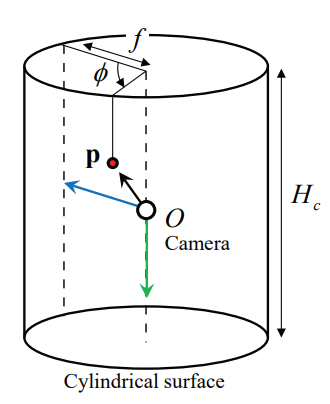

## Iterate over The Images and Update The Canvas

In [ ]:
    fig = plt.figure('HW1')
    plt.axis('off')

    for i, (im_i, rot_i) in enumerate(zip(im_list, rot_list)):

        # Project the 3D points to the i-th camera plane
        u, mask_i = Projection(p, K, rot_i, Wim, Him)

        # Warp the image to the cylindrical canvas
        canvas_i = WarpImage2Canvas(im_i, u, mask_i)

        # Update the canvas with the new warped image
        canvas = UpdateCanvas(canvas, canvas_i, mask_i)

    plt.imshow(canvas)
    plt.show()

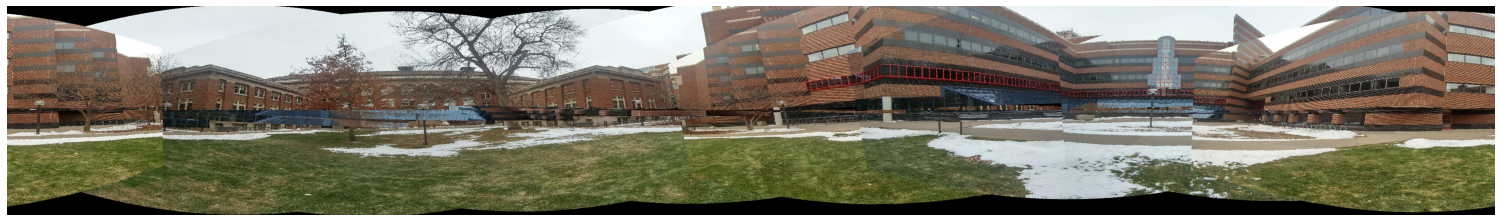